In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Build data

In [2]:
words = open('names.txt', 'r').read().split()

In [3]:
vocab = sorted(list(set(''.join(words))) + ['.'])
vocab_size = len(vocab)

stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}

In [107]:
block_size = 8

In [108]:
def build_dataset(words, bs = block_size):
    X, y = [], []

    for w in words:
        # print(w)
        context = [0] * bs
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            # print(''.join(itos[i] for i in context), '-->', itos[ix] )
            context = context[1:] + [ix]

    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X,y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr,ytr = build_dataset(words[:n1], block_size)
Xdev,ydev = build_dataset(words[n1:n2], block_size)
Xte,yte = build_dataset(words[n2:], block_size)

torch.Size([182441, 8]) torch.Size([182441])
torch.Size([22902, 8]) torch.Size([22902])
torch.Size([22803, 8]) torch.Size([22803])


In [109]:
for x,y in zip(Xtr[:15], ytr[:15]):
    print(''.join([itos[i] for i in x.tolist()]), "-->", itos[y.item()])

........ --> e
.......e --> l
......el --> i
.....eli --> a
....elia --> n
...elian --> y
..eliany --> s
.elianys --> .
........ --> t
.......t --> r
......tr --> o
.....tro --> y
....troy --> .
........ --> m
.......m --> a


# Model

In [110]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1) # flattens all dimensions
        return self.out
    
    def parameters(self):
        return []

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class BatchNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        self.dim = dim
        self.epsilon = epsilon
        self.training = True
        self.momentum = momentum

        self.gamma = torch.ones(self.dim)
        self.beta = torch.zeros(self.dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        hpreact = (x-xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * hpreact + self.beta

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# Let's simplify out layers into model : by PyTorch Containers
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [111]:
emb_dim = 10
n_hidden = 100
batch_size = 64

In [112]:
model = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(),
    Linear(block_size*emb_dim, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    for l in model.layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= (5/3)
 
    model.layers[-1].weight *= 0.1

parameters = model.parameters() #[p for l in layers for p in l.parameters()]
print(sum(p.numel() for p in parameters), 'parameters in the model')

for p in parameters:
    p.requires_grad = True

21597 parameters in the model


In [75]:
lossi = []
for i in range(200000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, yb)
    lossi.append(loss.item())

    if i % 20000 == 0 or i == 0:
        print(f'Iteration {i} | loss = {loss.item():.4f}')

    for p in parameters:
        p.grad = None

    loss.backward()

    # updates
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -(lr * p.grad)
    break

Iteration 0 | loss = 3.3018


In [59]:
# plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [60]:
for layer in model.layers:
    layer.training = False

In [61]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, ytr),
           'dev':   (Xdev, ydev),
           'test':  (Xte, yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'loss for {split} set: {loss.item()}')

split_loss('train')
split_loss('dev')

loss for train set: 1.9973578453063965
loss for dev set: 2.0978403091430664


In [65]:
# let's sample names

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()

        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

savyush.
thikaa.
camisidena.
dany.
hazitayli.


# Wavenet model

In [68]:
# batched matrix mulitply

((torch.rand(8,10)) @ (torch.rand(10,100)) + torch.randn(100)).shape

torch.Size([8, 100])

In [67]:
((torch.rand(8, 4, 10)) @ (torch.rand(10,100)) + torch.randn(100)).shape

torch.Size([8, 4, 100])

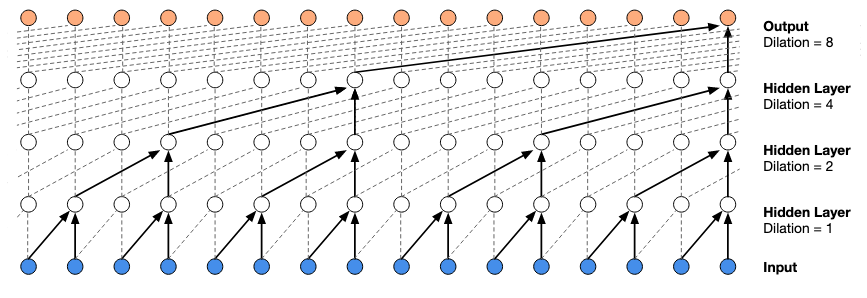

In [88]:
block_size = 8
X,y = build_dataset(words=words[:20], bs=block_size)

torch.Size([146, 8]) torch.Size([146])


In [89]:
# # (64,3,27)
# for layer in model.layers:
#     print(f'shape from       {layer.__class__.__name__} :   {layer.out.shape}')

In [92]:
model = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(),
    Linear(block_size*emb_dim, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    for l in model.layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= (5/3)
 
    model.layers[-1].weight *= 0.1

parameters = model.parameters() #[p for l in layers for p in l.parameters()]
print(sum(p.numel() for p in parameters), 'parameters in the model')

for p in parameters:
    p.requires_grad = True

21597 parameters in the model


In [93]:
ix = torch.randint(0, X.shape[0], (4,))
xb,yb = X[ix], y[ix]
# x.shape, y.shape
logits = model(xb)

xb.shape

torch.Size([4, 8])

In [103]:
model.layers[0].out.shape, model.layers[0].out.view(4,4,-1).shape, model.layers[0].out.view(4,2,-1).shape, model.layers[0].out.view(4,1,-1).squeeze(1).shape

(torch.Size([4, 8, 10]),
 torch.Size([4, 4, 20]),
 torch.Size([4, 2, 40]),
 torch.Size([4, 80]))

In [95]:
model.layers[1].out.shape

torch.Size([4, 80])

In [ ]:
# ((0,1) (2,3)) ((4,5) (6,7))

In [104]:
class FlattenConsecutive:
    def __init__(self, n_consecutive):
        self.n = n_consecutive
    
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, self.n*C) # flattens self.n consecutive dimensions
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        
        return self.out
    
    def parameters(self):
        return []

In [123]:
n_consecutive = 2
emb_dim = 10
n_hidden = 100
batch_size = 32

In [133]:
model = Sequential([
    Embedding(vocab_size, emb_dim),
    FlattenConsecutive(n_consecutive), Linear(n_consecutive * emb_dim, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive), Linear(n_consecutive * n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive), Linear(n_consecutive * n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    for l in model.layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= (5/3)

    model.layers[-1].weight *= 0.1

parameters = model.parameters() #[p for l in layers for p in l.parameters()]
print(sum(p.numel() for p in parameters), 'parameters in the model')

for p in parameters:
    p.requires_grad = True

45897 parameters in the model


In [ ]:
lossi = []
for i in range(200000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, yb)
    lossi.append(loss.item())

    if i % 20000 == 0 or i == 0:
        print(f'Iteration {i} | loss = {loss.item():.4f}')

    for p in parameters:
        p.grad = None

    loss.backward()

    # updates
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -(lr * p.grad)

Iteration 0 | loss = 3.2981


In [140]:
# for layer in model.layers:
#     print(f'{layer.__class__.__name__} --> {layer.out.shape}')

In [126]:
for layer in model.layers:
    layer.training = False

In [127]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, ytr),
           'dev':   (Xdev, ydev),
           'test':  (Xte, yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'loss for {split} set: {loss.item()}')

split_loss('train')
split_loss('dev')

loss for train set: 1.8983869552612305
loss for dev set: 2.0059220790863037


In [131]:
# let's sample names

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()

        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

abdurt.
corey.
sariah.
mechai.
aleigh.


In [137]:
class BatchNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        self.dim = dim
        self.epsilon = epsilon
        self.training = True
        self.momentum = momentum

        self.gamma = torch.ones(self.dim)
        self.beta = torch.zeros(self.dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        hpreact = (x-xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * hpreact + self.beta

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [148]:
n_consecutive = 2
emb_dim = 24
n_hidden = 128
batch_size = 32

model = Sequential([
    Embedding(vocab_size, emb_dim),
    FlattenConsecutive(n_consecutive), Linear(n_consecutive * emb_dim, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive), Linear(n_consecutive * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive), Linear(n_consecutive * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    for l in model.layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= (5/3)

    model.layers[-1].weight *= 0.1

parameters = model.parameters() #[p for l in layers for p in l.parameters()]
print(sum(p.numel() for p in parameters), 'parameters in the model')

for p in parameters:
    p.requires_grad = True

76579 parameters in the model


In [149]:
lossi = []
for i in range(200000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, yb)
    lossi.append(loss.item())

    if i % 20000 == 0 or i == 0:
        print(f'Iteration {i} | loss = {loss.item():.4f}')

    for p in parameters:
        p.grad = None

    loss.backward()

    # updates
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -(lr * p.grad)

Iteration 0 | loss = 3.2712
Iteration 20000 | loss = 1.8511
Iteration 40000 | loss = 2.3432
Iteration 60000 | loss = 2.0895
Iteration 80000 | loss = 1.9346
Iteration 100000 | loss = 1.5553
Iteration 120000 | loss = 1.7649
Iteration 140000 | loss = 1.5882
Iteration 160000 | loss = 1.7105
Iteration 180000 | loss = 1.6481


In [150]:
for layer in model.layers:
    layer.training = False

In [151]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, ytr),
           'dev':   (Xdev, ydev),
           'test':  (Xte, yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'loss for {split} set: {loss.item()}')

split_loss('train')
split_loss('dev')

loss for train set: 1.7913916110992432
loss for dev set: 1.9861246347427368


In [155]:
# let's sample names

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()

        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

mahiba.
sydylin.
brod.
suhaya.
azrika.
